In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [66]:
df = pd.read_csv('../data/cleaned.csv', index_col='id')

In [67]:
df = pd.read_csv('../data/cleaned.csv', index_col='id')

X = df[[col for col in df.columns if col != 'target']]
y = df['target']

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

#### RandomForestClassifier for feature selection

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [69]:
from sklearn.metrics import accuracy_score
pre = rf.predict(X_test)

print(f"Testing Accuracy: {accuracy_score(pre, y_test):.2f}")

Testing Accuracy: 0.85


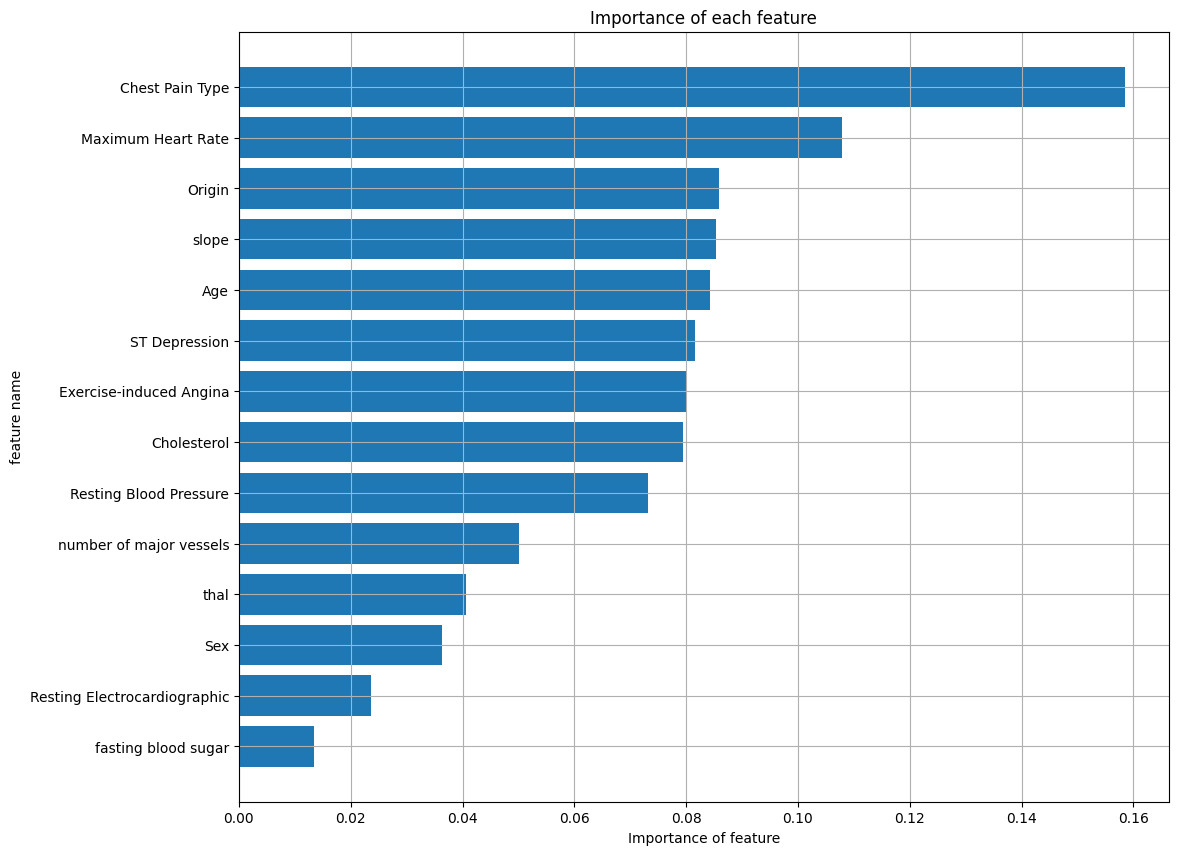

In [70]:
df2 = pd.DataFrame({
  'Feature': X.columns,
  'Importance': rf.feature_importances_
}).sort_values(by='Importance')

plt.figure(figsize=(12, 10))
plt.barh(width=df2['Importance'], y=df2['Feature'])
plt.grid(True)
plt.xlabel("Importance of feature")
plt.ylabel("feature name")
plt.title("Importance of each feature")
plt.show()

In [71]:
# elbow method to get the best number of features
arr = []
for i in range(1, df2['Feature'].size+1):
  selected = df2.iloc[-i:]['Feature'].unique()

  rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
  rf2.fit(X_train[selected], y_train)

  pre = rf2.predict(X_test[selected])

  arr.append([i, accuracy_score(pre, y_test)])

Text(0.5, 1.0, 'Best number of features')

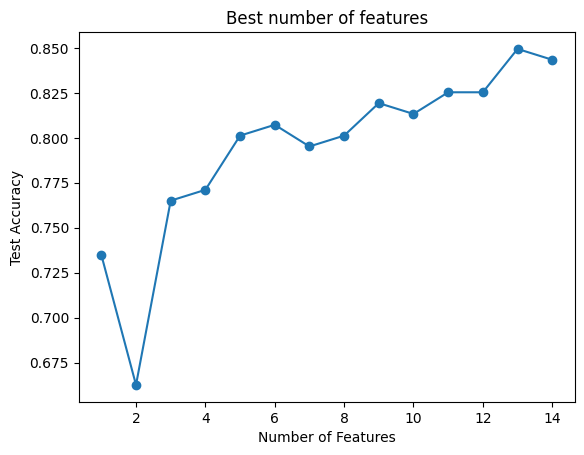

In [72]:
arr = np.array(arr)
plt.plot(arr[:,0], arr[:,1], marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Test Accuracy")
plt.title("Best number of features")

In [73]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE, SelectKBest, chi2

# 11 as the best result
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100,random_state=42), n_features_to_select=11)
rfe.fit(X, y)

X_selected = rfe.transform(X)

### Chi-Square Test

In [74]:
from sklearn.preprocessing import MinMaxScaler

# apply min-max scaler to eliminate negative values caused by standard scaler
scaler = MinMaxScaler()

chi2_selector = SelectKBest(score_func=chi2, k='all')
pos = scaler.fit_transform(X)

chi2_selector.fit(pos, y)

chi2_scores = pd.DataFrame({
  'Feature': X.columns,
  'Chi2 Score': chi2_selector.scores_,
  'p-Value': chi2_selector.pvalues_
}).sort_values(by='Chi2 Score', ascending=False)

print("\nChi-Square Test Results:")
chi2_scores


Chi-Square Test Results:


,Feature,Chi2 Score,p-Value
9,Exercise-induced Angina,108.425613,2.168375e-25
3,Chest Pain Type,50.058092,1.492610e-12
2,Origin,27.554650,1.527178e-07
11,slope,22.513787,2.086408e-06
1,Sex,18.483338,1.713962e-05
12,number of major vessels,8.840628,2.945977e-03
8,Maximum Heart Rate,7.839097,5.112814e-03
10,ST Depression,7.570134,5.934338e-03
6,fasting blood sugar,6.451247,1.108745e-02
0,Age,4.666921,3.074900e-02


In [75]:
selected_cols = X.columns[rfe.support_]
selected_cols

Index(['Age', 'Origin', 'Chest Pain Type', 'Resting Blood Pressure',
       'Cholesterol', 'Maximum Heart Rate', 'Exercise-induced Angina',
       'ST Depression', 'slope', 'number of major vessels', 'thal'],
      dtype='object')

In [76]:
final = np.c_[X_selected, y] # combine features with target variable

# Save as csv to use in another file
final = pd.DataFrame(final, columns=[*selected_cols, 'target'])
final.to_csv('../data/feature_selected.csv')